### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions

from stable_baselines3 import A2C
import quantstats as qs

### Create Env

In [2]:
# df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

import yfinance as yf

tsla = yf.Ticker("TSLA")
df = tsla.history(period="max")

window_size = 100
start_index = window_size
end_index = len(df)

env = gym.make(
    'stocks-v0',
    df=df,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

print("observation_space:", env.observation_space)

observation_space: Box(-10000000000.0, 10000000000.0, (100, 2), float32)


### Train Env

In [3]:
env.reset(seed=2023)
model = A2C('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=1000)

### Test Env

In [4]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 1583, <Actions.Buy: 1>: 1791}
info: {'total_reward': 147.3961409330368, 'total_profit': 4.1421400047809585e-05, 'position': <Positions.Long: 1>}


Note: Now it seems like the total reward and total profit are always random even with same conditions.

Original _calculate_reward: "total reward': 22.757816076278687, total profit': 2.5950764076197875e-05

Updated _calculate_reward: "total reward": 284.1998771429062, "total profit': 0.00022276239028290592 (window_size = 30)

Updated _calculate_reward: "total reward": 16.919933319091797, "total profit': 0.024492081037512724 (window_size = 40)

Updated _calculate_reward: "total reward": 134.7667487859726, "total profit': 3.476755860688552e-05 (window_size = 100)

Updated _calculate_reward: "total reward": -111.78442347049713, "total profit': 7.968085116505978e-06 (window_size = 100)

### Plot Results

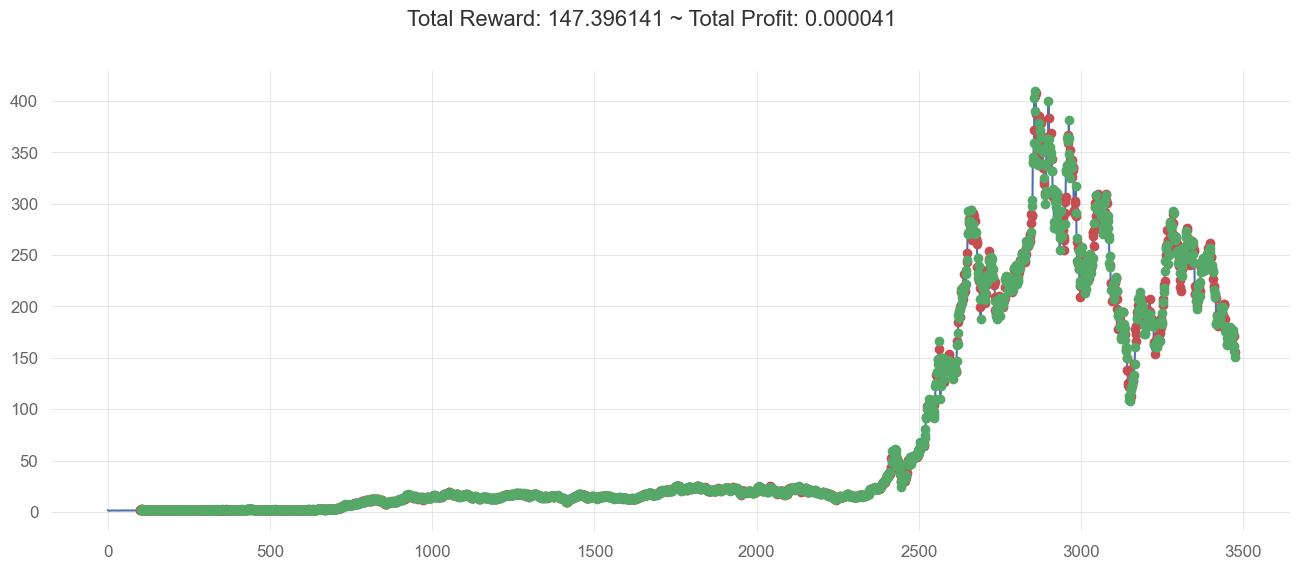

In [5]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

### Analysis Using `quantstats`

                           Strategy
-------------------------  ----------
Start Period               2010-11-22
End Period                 2024-04-18
Risk-Free Rate             0.0%
Time in Market             26.0%

Cumulative Return          -100.0%
CAGR﹪                     -40.51%

Sharpe                     -1.58
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -1.57
Sortino                    -2.1
Smart Sortino              -2.08
Sortino/√2                 -1.49
Smart Sortino/√2           -1.47
Omega                      0.56

Max Drawdown               -100.0%
Longest DD Days            4886
Volatility (ann.)          42.04%
Calmar                     -0.41
Skew                       0.98
Kurtosis                   29.93

Expected Daily %           -0.3%
Expected Monthly %         -6.04%
Expected Yearly %          -48.97%
Kelly Criterion            -28.7%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.62%
Expected Shortfall (cVaR)  -4.62%

Max Consecutive

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2010-12-03,2024-04-17,2024-04-18,4885,-99.995937,-99.994553


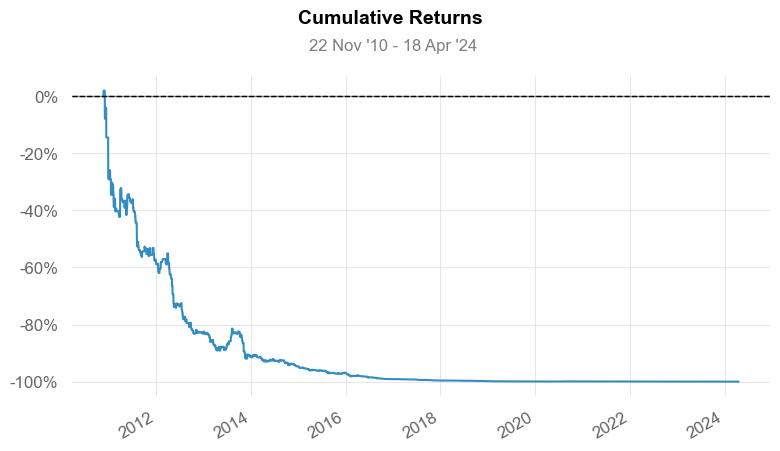

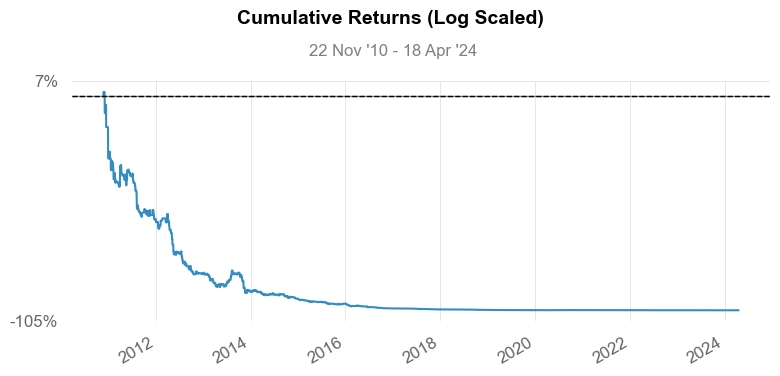

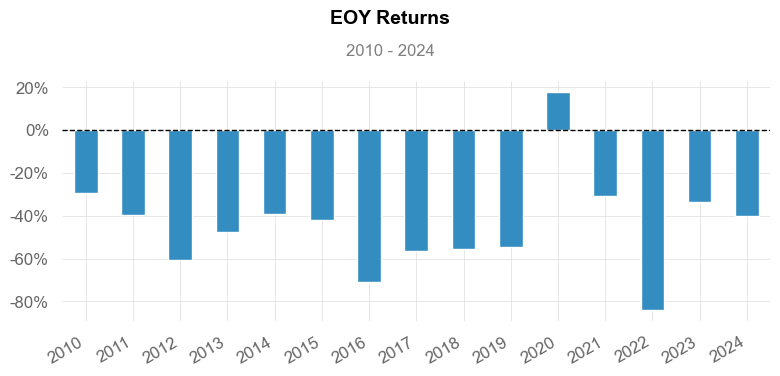

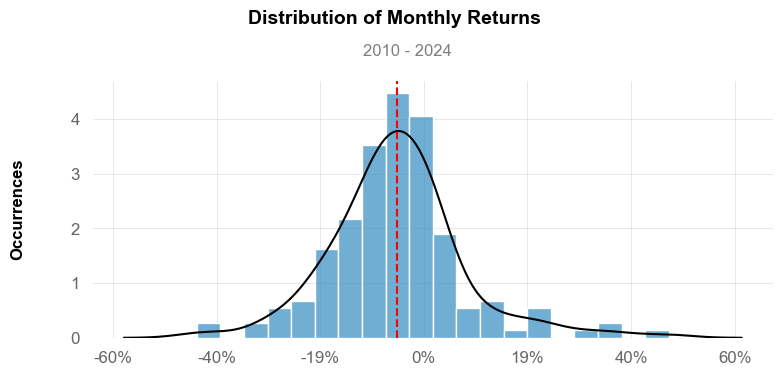

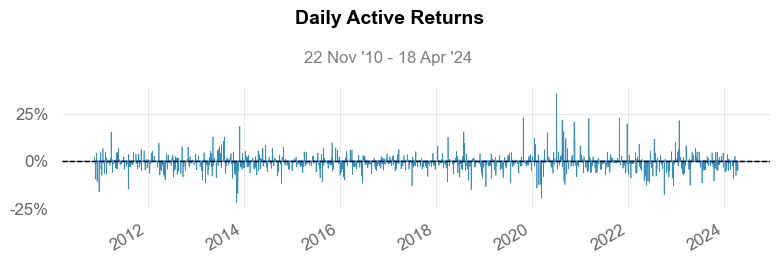

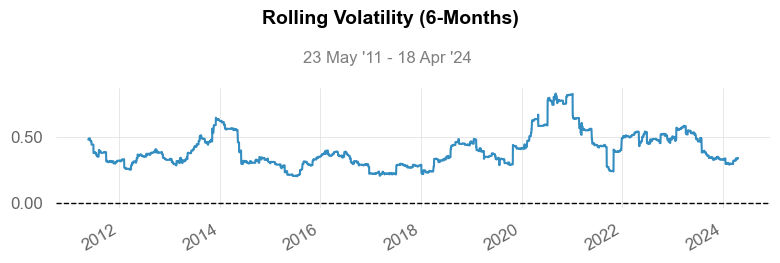

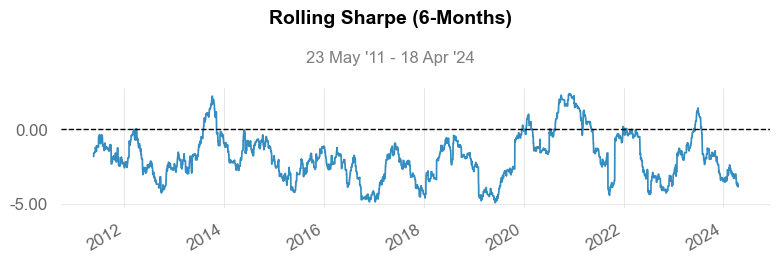

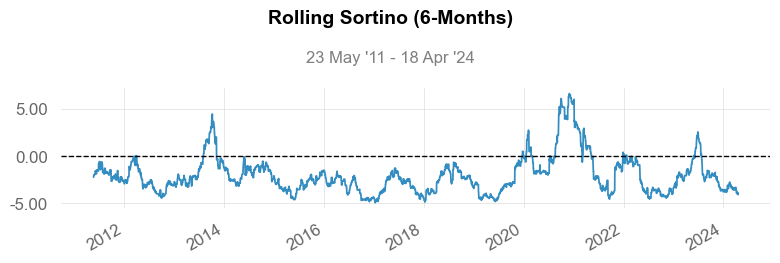

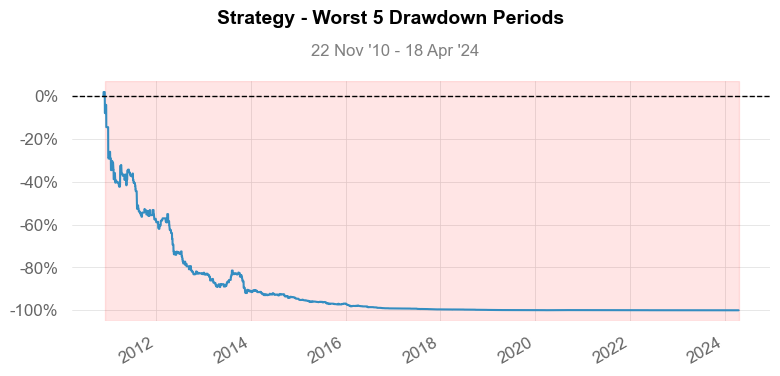

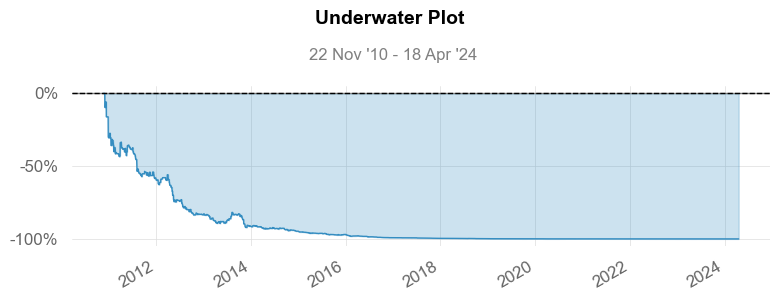

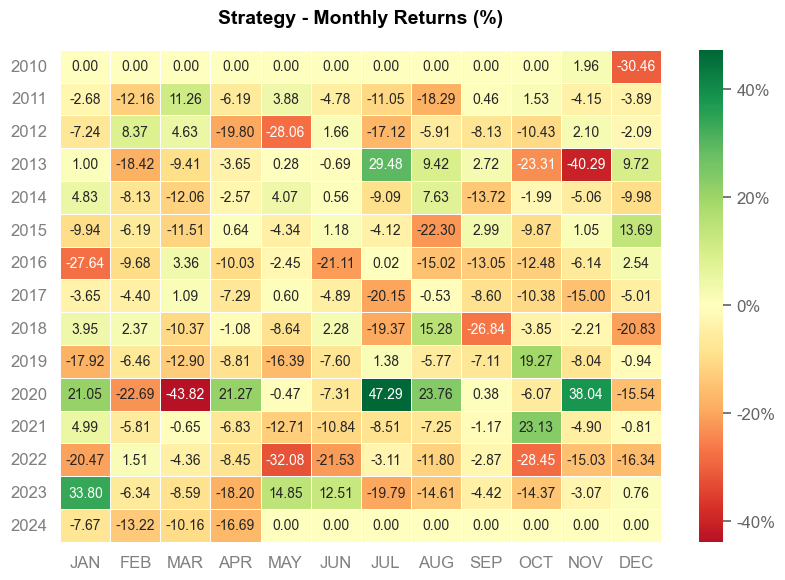

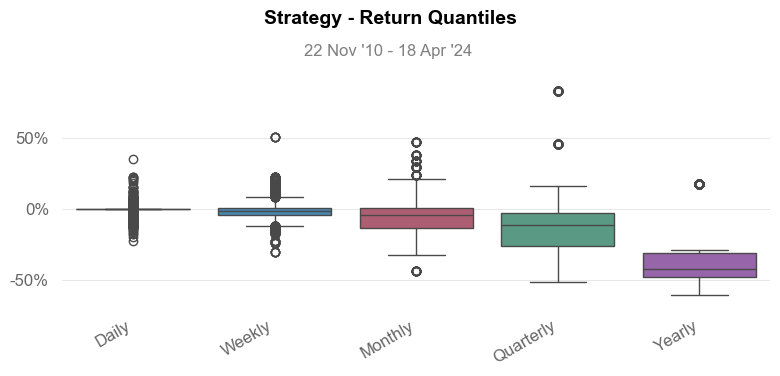

In [6]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats.html')